# DASC simulator

In [1]:
import numpy as npy
import EMfields as em
import RefractiveIndex as ri
import matplotlib.pyplot as plt
import opticalCrossSection as ocs
import scipy.integrate as integrate
from scipy.interpolate import interp1d

In [2]:
# Input variables

mat = 'Au'                  # NP material
rhonp = 19300               # NP density (kg/m^3)
Cnp = 129                   # NP heat capacity (J/kg.K)
knp = 315                   # NP thermal conductivity (W/m.K)
a_np = 50                   # NP radius (nm)
p = 5e-5                    # NF volume fraction

#mat = 'PDA'                 # NP material
#rhonp = 1520                # NP density (kg/m^3)
#Cnp = 1500                  # NP heat capacity (J/kg.K)
#knp = 0.2                   # NP thermal conductivity (W/m.K)
#a_np = 135/2                # NP radius (nm)
#p = 3.84e-4                 # NF volume fraction

rhobf = 1000                # Basefluid density (kg/m^3)
ubf = 8.9e-4                # Basefluid viscosity (N.s/m^2)
Cbf = 4182                  # Basefluid heat capacity (J/kg.K)
kbf = 0.598                 # Basefluid thermal conductivity (W/m.K)

Tin = 298.15                # Fluid input temperature (K)
Tamb = 298.15               # Ambient temperature (K)
Tsun = 5800.0               # Sun's temperature (K)
U = 0.002                   # Fluid flow speed (m/s)

H = 1e-2                    # DASC thickness (m)
L = 1                       # DASC length (m)
Ac = 1                      # DASC area (m^2)
h = 10                      # Heat transfer coefficient (W/m^2.K)

Acs = Ac*H/L                # DASC cross-sectional area (m^2)


# Thermophysical properties of the nanofluid
rhonf = (1 - p)*rhobf + p*rhonp
unf = (1 + 2.5*p)*ubf
Cnf = ((1 - p)*rhobf*Cbf + p*rhonp*Cnp)/rhonf
knf = ((knp + 2*kbf + 2*p*(knp - kbf))/(knp + 2*kbf - p*(knp - kbf)))*kbf

mdot = rhonf*Acs*U          # Mass flow rate (kg/s)


In [3]:
# Importing solar irradiance spectrum

solar = npy.loadtxt("Materials//SolarSpectrum.txt",skiprows=1)
wl_solar = solar[:,0]
I_solar = solar[:,1]
f_solar = interp1d(wl_solar, I_solar)   # Interpolate solar irradiance spectrum    

lambda_min = 300
lambda_max = 1200

wl = npy.linspace(lambda_min,lambda_max,lambda_max-lambda_min+1)
I0 = integrate.cumulative_trapezoid(f_solar(wl), wl, initial=0)[-1]
print(str(I0)+' W/m^2')

836.0815167499997 W/m^2


In [4]:
 # Meshing

nx = 50                     # Number of cells in x direction
ny = 100                    # Number of cells in y direction

DX = L/nx                   # Slicing x axis
DY = H/ny                   # Slicing y axis

X = npy.linspace(0, L, nx)
Y = npy.linspace(0, H, ny)
x, y = npy.meshgrid(X, Y)
u = npy.full((nx, ny), Tin)
print(u.shape)

(50, 100)


In [5]:
# Defining heat source

# Basefluid absorption
Water = npy.loadtxt("Materials\\n_Water.txt")
wl_Water = Water[:,0]*(1e3)
k_Water = Water[:,1]*(1e-9)
alpha_bf = 4*npy.pi*k_Water/wl_Water
f_bf = interp1d(wl_Water, alpha_bf)

# NP absorption
Vnp = (4*npy.pi/3)*((a_np*(1e-9))**3)

wl_np, N_np, N1_np, N2_np, mu1_np, mu2_np = ri.setupRI(mat,'Water','Water',a_np,a_np,lambda_min,lambda_max,False,False)
Csca_np, Cext_np, Cabs_np, Cbck_np = ocs.sphereCS(wl_np*(1e9),N2_np,N_np,mu2_np,a_np)

wl_np = npy.delete(wl_np,len(wl_np)-1)*(1e9)
Cabs_np = npy.delete(Cabs_np,len(Cabs_np)-1)*(1e-18)

alpha_np = p*Cabs_np/Vnp
f_np = interp1d(wl_np, alpha_np)

def f_nf(lbda): return f_bf(lbda) + f_np(lbda)

def heat_source(pos_y):
    #def prod_np(z): return f_solar(z)*f_np(z)*npy.exp(-f_np(z)*pos_y)
    def prod_nf(z): return f_solar(z)*f_nf(z)*npy.exp(-f_nf(z)*pos_y)
    wltmp = npy.linspace(lambda_min,lambda_max,lambda_max-lambda_min+1)
    #inttmp = prod_np(wltmp)
    inttmp = prod_nf(wltmp)
    hs = integrate.cumulative_trapezoid(inttmp, wltmp, initial=0)[-1]
    return hs

hs = []
for q in range(len(Y)):
    hs.append(heat_source(Y[q]))       
hs = npy.array(hs)

print(npy.sum(hs)*DY)

614.6520188105432


In [6]:
# Assigning constant temperature boundary condition
u[:,0] = Tin

# Initializing changing boundaries
u[0,:] = Tamb
u[-1,:] = Tamb

### Simulation

In [7]:
# Residual error
E = []

# Iteration and tolerance
iter = 1
tol = 1

while tol > 1e-4:
    w = u.copy()

    u[0,:] = Tin

    for ii in range(1,nx - 1):
        u[ii,0] = (2*w[ii,1] + 2*(h*DY/knf)*Tamb + (rhonf*Cnf*U*(DY**2)/(DX*knf))*w[ii-1,0] - ((DY**2)/(knf))*hs[0])/(2 + 2*h*DY/knf + rhonf*Cnf*U*(DY**2)/(knf*DX))

        for jj in range(1,ny - 1):
            if jj == ny - 1:
                u[ii,jj] = w[ii,jj - 1]
            else:
                u[ii,jj] = (w[ii,jj+1] + w[ii,jj-1])/2 + ((DY**2)/(2*knf))*hs[jj] - ((rhonf*Cnf*U*(DY**2))*(w[ii+1,jj] - w[ii-1,jj]))/(4*knf*DX)

    u[-1,:] = u[-2,:]
    Tout = npy.average(u[-1,:])

    tol = npy.sqrt(npy.sum((u - w)**2))
    E.append(tol)
    iter += 1

E = npy.array(E)                                                                                        # Vectorize tolerance list

Th_eta = mdot*Cnf*(Tout - Tin)/(I0*Ac)                                                                  # Thermal efficiency
Ex_eta = mdot*Cnf*(Tout - Tin)*(1 - Tamb/Tout)/(I0*Ac*(1 - 4*Tamb/(3*Tsun) + (Tamb**4)/(3*(Tsun**4))))  # Exergy efficiency

print("\n\nTolerance of "+str(tol)+" achieved after "+str(iter)+" iterations.")

print("-----------------------------------------------------------------------------------")
print("INPUT:")
print("Mat:\t"+str(mat))
print("p:\t"+str(p))
print("a_np:\t"+str(a_np)+" nm")
print("H:\t"+str(H)+" m")
print("Tin:\t"+str(Tin)+" K")
print("-----------------------------------------------------------------------------------")
print("OUTPUT:")
print("Tout:\t"+str(Tout)+" K")
print("Th_eff:\t"+str(Th_eta))
print("Ex_eff:\t"+str(Ex_eta))
print("-----------------------------------------------------------------------------------")

f = open('DASC results\\DASC_log.txt','w')
f.write("Tolerance of "+str(tol)+" achieved after "+str(iter)+" iterations.")
f.write("\n\n-----------------------------------------------------------------------------------")
f.write("\nINPUT:")
f.write("\nMat:\t"+str(mat))
f.write("\np:\t"+str(p))
f.write("\na_np:\t"+str(a_np)+" nm")
f.write("\nH:\t"+str(H)+" m")
f.write("\nTin:\t"+str(Tin)+" K")
f.write("\n-----------------------------------------------------------------------------------")
f.write("\nOUTPUT:")
f.write("\nTout:\t"+str(Tout)+" K")
f.write("\nTh_eff:\t"+str(Th_eta))
f.write("\nEx_eff:\t"+str(Ex_eta))
f.write("\n-----------------------------------------------------------------------------------")
f.close()



Tolerance of 9.998283701694072e-05 achieved after 75152 iterations.
-----------------------------------------------------------------------------------
INPUT:
Mat:	Au
p:	5e-05
a_np:	50 nm
H:	0.01 m
Tin:	298.15 K
-----------------------------------------------------------------------------------
OUTPUT:
Tout:	301.05141642035045 K
Th_eff:	0.29024629114443995
Ex_eff:	0.0030031075164820135
-----------------------------------------------------------------------------------


### Results and export

C:\Users\Tulio\AppData\Local\Temp\ipykernel_18008\2048668138.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis1.set_yticklabels(['','1.0','0.8','0.6','0.4','0.2','0.0'])
C:\Users\Tulio\AppData\Local\Temp\ipykernel_18008\2048668138.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis1.set_xticklabels(['','0','0.2','0.4','0.6','0.8','1.0'])


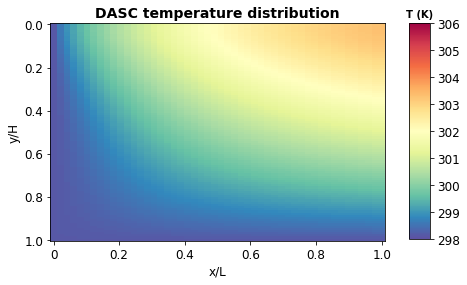

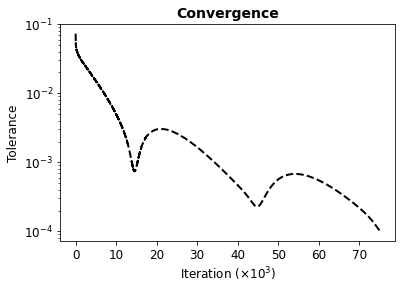

In [8]:
fig1, axis1 = plt.subplots()
axis1.set_title('DASC temperature distribution', fontsize=14, fontweight='bold')
pcm1 = axis1.pcolormesh(X, -Y, u.transpose(), cmap=plt.cm.Spectral_r, vmin=298, vmax=306)
axis1.set_ylabel('y/H', fontsize=12)
axis1.set_xlabel('x/L', fontsize=12)
axis1.tick_params(axis='x', labelsize=12)
axis1.tick_params(axis='y', labelsize=12)
axis1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
axis1.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
axis1.set_yticklabels(['','1.0','0.8','0.6','0.4','0.2','0.0'])
axis1.set_xticklabels(['','0','0.2','0.4','0.6','0.8','1.0'])
cbar_axs1 = fig1.add_axes([0.955, 0.130, 0.05, 0.752])
cbar1 = fig1.colorbar(pcm1, cax=cbar_axs1)
cbar1.ax.tick_params(labelsize=12)
cbar1.ax.set_title('T (K)', fontsize=10, fontweight='bold')
plt.show()

npy.savetxt('DASC results\\Temperature distribution X axis.txt', X, delimiter ='\t')
npy.savetxt('DASC results\\Temperature distribution Y axis.txt', Y, delimiter ='\t')
npy.savetxt('DASC results\\Temperature distribution map.txt', u, delimiter ='\t')

fig2, axis2 = plt.subplots()
axis2.set_title("Convergence", fontsize=14, fontweight='bold')
n_inter = npy.linspace(0,len(E)-1,len(E))+1
axis2.plot(n_inter/1000, E, '--', linewidth=2, color='k')
axis2.set_yscale('log')
axis2.set_ylabel('Tolerance', fontsize=12)
axis2.set_xlabel('Iteration ($\\times 10^3$)', fontsize=12)
axis2.tick_params(axis='x', labelsize=12)
axis2.tick_params(axis='y', labelsize=12)
plt.show()

npy.savetxt('DASC results\\Convergence.txt', E, delimiter ='\t')

### Beer attenuation analysis

In [9]:
# Beer-attenuation (per wavelength)
def beer():
    atten = f_solar(wl)*npy.exp(-f_nf(wl)*H)
    return atten

def beer_map():
    wl_fine = npy.linspace(lambda_min, lambda_max, lambda_max-lambda_min+1)
    #YY = npy.linspace(0, hh, ny+1)
    uu = npy.zeros((len(wl_fine), ny + 1))
    for ii in range(0,len(wl_fine)):
        for jj in range(0,ny):
            uu[ii,jj] = f_solar(wl_fine[ii])*npy.exp(-f_nf(wl_fine[ii])*Y[jj])

    return wl_fine, uu

In [10]:
solar_beer = beer()
wl_X, power_dist = beer_map()

npy.savetxt('DASC results\\Beer colormap.txt', npy.c_[wl_X, power_dist], delimiter ='\t')
npy.savetxt('DASC results\\Beer attenuation.txt', npy.c_[wl, solar_beer], delimiter ='\t')

C:\Users\Tulio\AppData\Local\Temp\ipykernel_18008\1017864460.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs3['Top'].set_yticklabels(labelsa3)


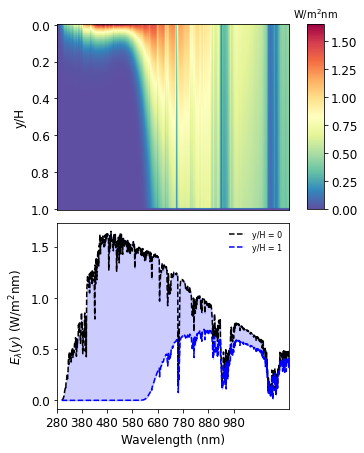

In [11]:
fig3 = plt.figure(constrained_layout=True, figsize=(4,6))
axs3 = fig3.subplot_mosaic([['Top'],['Bottom']], sharex=False)

labelsa3 = ['','0.0','0.2','0.4','0.6','0.8','1.0']
labelsb3 = ['', '', '', '', '', '']

imtst3 = axs3['Top'].imshow(power_dist.transpose(), cmap=plt.cm.Spectral_r, aspect='auto')
axs3['Top'].set_ylabel('y/H', fontsize=12)
axs3['Top'].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs3['Top'].tick_params(axis='x', labelsize=12)
axs3['Top'].tick_params(axis='y', labelsize=12)
axs3['Top'].set_yticklabels(labelsa3)

p3a1, = axs3['Bottom'].plot(wl, f_solar(wl), 'k', linestyle='--', linewidth=1.5, label='y/H = 0')
axs3['Bottom'].fill_between(wl, f_solar(wl), solar_beer, alpha=0.2, color='b')
p3a2, = axs3['Bottom'].plot(wl,solar_beer, 'b', linestyle='--', linewidth=1.5, label='y/H = 1')
axs3['Bottom'].set_xlim([lambda_min,lambda_max])
#axs3['Bottom'].set_xticks([350,550,750,950,1150])
axs3['Bottom'].set_xticks([280,380,480,580,680,780,880,980])
axs3['Bottom'].legend(handles=[p3a1,p3a2], frameon=False, prop={'size': 8}, loc='upper right')
axs3['Bottom'].set_ylabel('$E_\lambda (y)$ (W/m$^\mathrm{2}$nm)', fontsize=12)
axs3['Bottom'].set_xlabel('Wavelength (nm)', fontsize=12)
axs3['Bottom'].tick_params(axis='x', labelsize=12)
axs3['Bottom'].tick_params(axis='y', labelsize=12)

cbar_axs3 = fig3.add_axes([1.05, 0.555, 0.06, 0.428])
cbar3 = fig3.colorbar(imtst3, cax=cbar_axs3)
cbar3.ax.tick_params(labelsize=12)
cbar3.ax.set_title('W/m$^\mathrm{2}$nm', fontsize=10)

plt.show()

### Solar weighted absorption coefficient (Am)

In [12]:
# Solar weighted absorption coefficient (Am)
def Am(pp, hh):
    alpha_np_tmp = pp*Cabs_np/Vnp
    f_np_tmp = interp1d(wl_np, alpha_np_tmp)

    def f_nf_tmp(z): return f_np_tmp(z) + f_bf(z) # Total absorption
    def prod_np(z): return f_solar(z)*(1 - npy.exp(-f_nf_tmp(z)*hh))
    inttmp = prod_np(wl)
    SWABC = integrate.cumulative_trapezoid(inttmp, wl, initial=0)[-1]/I0
    return SWABC

In [13]:
p_range = npy.linspace(0,5e-5)
h_range = npy.linspace(0,2.5e-2)
Am_map = npy.zeros((len(h_range),len(p_range)))

for iii in range(len(h_range)):
    for jjj in range(len(p_range)):
        Am_map[iii,jjj] = Am(h_range[iii], p_range[jjj])

npy.savetxt('DASC results\\Am p.txt', p_range, delimiter ='\t')
npy.savetxt('DASC results\\Am H.txt', h_range, delimiter ='\t')
npy.savetxt('DASC results\\Am map.txt', Am_map, delimiter ='\t')

C:\Users\Tulio\AppData\Local\Temp\ipykernel_18008\3487897160.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs4.set_yticklabels(labelsy4)
C:\Users\Tulio\AppData\Local\Temp\ipykernel_18008\3487897160.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs4.set_xticklabels(labelsx4)


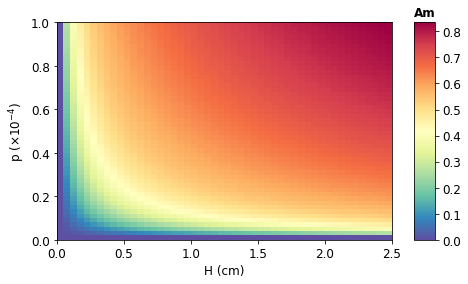

In [14]:
fig4, axs4 = plt.subplots()

labelsx4 = ['0.0','0.5','1.0','1.5','2.0','2.5']
#labelsy4 = ['0','1','2','3','4','5']
labelsy4 = ['0.0','0.2','0.4','0.6','0.8','1.0']

imtst4 = axs4.pcolormesh(Am_map, cmap=plt.cm.Spectral_r)
axs4.set_ylabel('p ($\\times$10$^\mathrm{-4}$)', fontsize=12)
axs4.set_xlabel('H (cm)', fontsize=12)
axs4.tick_params(axis='x', labelsize=12)
axs4.tick_params(axis='y', labelsize=12)
axs4.set_yticklabels(labelsy4)
axs4.set_xticklabels(labelsx4)

cbar_axs4 = fig4.add_axes([0.951, 0.125, 0.05, 0.755])
cbar4 = fig4.colorbar(imtst4, cax=cbar_axs4)
cbar4.ax.tick_params(labelsize=12)
cbar4.ax.set_title('Am', fontsize=12, fontweight='bold')

plt.show()
